# ***Projet de Détection de la Fatigue chez les Apprenants***

#### *L'objectif essentiel est d'établir un système de détection de la fatigue chez les apprenants au sein d'une salle de classe équipée de caméras.* 

#### *La méthode de détection s'appuie sur le calcul du "eye aspect ratio" (EAR), déterminé par la position des points d'intérêt (p1, p2, ..., p6) autour des yeux.*

## ***Importation des bibliothèques***

In [1]:
# OpenCV - Bibliothèque de vision par ordinateur, utilisée pour la capture vidéo, le traitement d'image, etc.
import cv2  

# Module pour les opérations liées au système d'exploitation, utilisé ici pour la gestion des chemins de fichiers.
import os  

# Bibliothèque Dlib - Utilisée pour la détection de visage et l'analyse des points d'intérêt des yeux.
import dlib 

# Bibliothèque Imutils - est souvent utilisée pour des opérations courantes de traitement d'image et pour rendre le code plus facile à comprendre.
import imutils  

# Fonctions utilitaires spécifiques pour le traitement des visages avec Imutils.
from imutils import face_utils  

# SciPy - Bibliothèque pour les opérations scientifiques, utilisée ici pour calculer les distances entre des points.
from scipy.spatial import distance as dist  

# NumPy - Bibliothèque pour le calcul numérique, utilisé pour traiter les coordonnées des points d'intérêt du visage et des yeux détectés par Dlib.
import numpy as np  

# Module pour la manipulation des fichiers CSV, utilisé ici pour stocker les résultats de EAR.
import csv  

# Module pour la gestion des dates et heures, utilisé ici pour horodater les résultats.
from datetime import datetime

# Module pour la gestion des threads, utilisé pour déclencher des alertes de manière asynchrone.
from threading import Thread  

# Pygame - Bibliothèque pour le développement de jeux, utilisée ici pour la lecture d'alertes sonores.
import pygame  

# Module pour la gestion du temps, utilisé pour les pauses et les mesures de durée.
import time  

# matplotlib.pyplot est utilisé pour créer des visualisations des images
import matplotlib.pyplot as plt

# matplotlib.image est utilisé pour lire et afficher des images
import matplotlib.image as mpimg

pygame 2.5.2 (SDL 2.28.3, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


##  ***1. Extraction des images à partir d'une vidéo.***

#### *Cette fonction **extract_images** prend en entrée un chemin vers une vidéo (**video_path**), un dossier de sortie (**output_folder**) et un intervalle de temps (**time_interval**).*
#### *Elle extrait des images de la vidéo à des intervalles réguliers définis par **time_interval** et les enregistre dans le dossier de sortie.*

In [9]:
def extract_images(video_path, output_folder, time_interval=10):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Chargement de la vidéo à partir du chemin spécifié
    cap = cv2.VideoCapture(video_path)

    # Obtenir la fréquence d'images (fps) de la vidéo
    # La fréquence d'images est le nombre d'images (ou trames) affichées par seconde dans une séquence vidéo.
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculer le nombre de trames à sauter entre chaque capture d'image, en fonction de l'intervalle de temps souhaité
    frame_interval = int(fps * time_interval)

    # Initialiser le compteur de trames
    frame_count = 0

    # Si le numéro de la trame est un multiple du frame_interval, 
    # enregistrement de cette trame sous forme d'image dans le dossier de sortie avec un nom de fichier indiquant le numéro de la trame.
    while True:
        # Lire la trame
        ret, frame = cap.read()

        # Vérifier s'il reste des trames
        if not ret:
            break

        # Incrémenter le compteur de trames
        frame_count += 1

        # Si le numéro de la trame est un multiple du frame_interval, enregistrez l'image
        if frame_count % frame_interval == 0:
            output_path = os.path.join(output_folder, f"frame_{frame_count}.jpg")
            cv2.imwrite(output_path, frame)

    # Libérer la capture vidéo
    cap.release()

    # Affichage d'un message de succès
    print(f"Les Images sont bien enregistrées dans le dossier : {output_folder}")


In [10]:
if __name__ == "__main__":
    video_path = "Scènes_Classe.mp4"
    output_folder = "captured_images"
    frame_interval = 15 

    extract_images(video_path, output_folder, frame_interval)

Les Images sont bien enregistrées dans le dossier : captured_images


## ***Une fonction qui affiches les images en RGB***

In [38]:
def show_random_images(folder_path, num_images=5):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    if not image_files:
        print(f"No images found in the folder: {folder_path}")
        return

    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(20, 3 * (num_images // 5 + 1)))

    for i, image_file in enumerate(selected_images, start=1):
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)

        plt.subplot(num_images // 5 + 1, 5, i)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

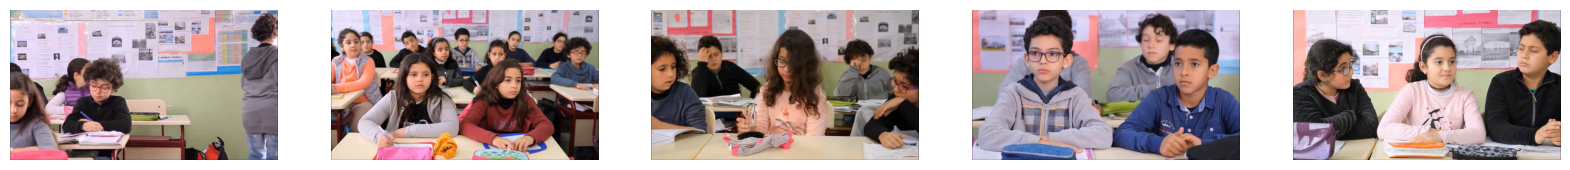

In [39]:
if __name__ == "__main__":
    folder_path = "captured_images"
    num_images_to_show = 5
    show_random_images(folder_path, num_images_to_show)

##  ***2. Conversion des images en niveaux de gris.***

#### *Cette fonction, **convert_images_to_grayscale**, prend en entrée un dossier contenant des images en couleur (JPEG ou PNG) et génère des versions en niveaux de gris de ces images dans un dossier de sortie spécifié.*

In [50]:
def convert_images_to_grayscale(input_folder, output_folder):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Parcourir toutes les images dans le dossier d'entrée
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Charger l'image en couleur
            color_image_path = os.path.join(input_folder, filename)
            color_image = cv2.imread(color_image_path)

            # Convertir l'image en niveaux de gris
            gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

            # Enregistrer l'image en niveaux de gris dans le dossier de sortie
            output_path = os.path.join(output_folder, f"{filename.split('.')[0]}.jpg")
            cv2.imwrite(output_path, gray_image)
            
    print(f"Les Images en niveaux de gris sont bien enregistrées dans le dossier : {output_folder}")

In [42]:
if __name__ == "__main__":
    input_folder = "captured_images"
    output_folder = "GrayScale_Images"

    convert_images_to_grayscale(input_folder, output_folder)

Les Image en niveaux de gris sont bien enregistrée dans le dossier : GrayScale_Images


## ***Une fonction qui affiches les images en niveau de Gris***

In [44]:
def show_random_images_grayScale(folder_path, num_images=5):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    if not image_files:
        print(f"No images found in the folder: {folder_path}")
        return

    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(20, 3 * (num_images // 5 + 1)))

    for i, image_file in enumerate(selected_images, start=1):
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)

        plt.subplot(num_images // 5 + 1, 5, i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.show()

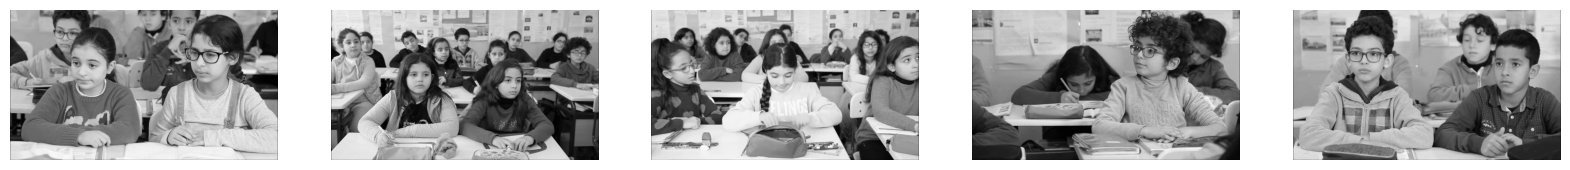

In [45]:
if __name__ == "__main__":
    folder_path = "GrayScale_Images"
    num_images_to_show = 5
    show_random_images_grayScale(folder_path, num_images_to_show)

##  ***3. Suppression de bruits.***

#### *Cette fonction **denoise_images** traite les images situées dans un dossier d'entrée en appliquant un filtrage **median**.*

In [51]:
def denoise_images(input_folder, output_folder):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Liste des fichiers dans le dossier d'entrée
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # Chemin complet de l'image d'entrée
        input_path = os.path.join(input_folder, image_file)

        # Lire l'image en niveaux de gris
        gray_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Appliquer un filtre de flou médian pour supprimer le bruit
        denoised_image = cv2.medianBlur(gray_image, 5)  # Le deuxième paramètre est la taille du noyau

        # Chemin complet de l'image de sortie
        output_path = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}.jpg")

        # Enregistrer l'image traitée
        cv2.imwrite(output_path, denoised_image)
        
    print(f"Les Images sont bien enregistrées après suppression de bruit dans le dossier : {output_folder}")

In [52]:
if __name__ == "__main__":
    input_folder = "GrayScale_Images"
    output_folder = "denoised_images"

    denoise_images(input_folder, output_folder)

Les Images sont bien enregistrées après suppression de bruit dans le dossier : denoised_images


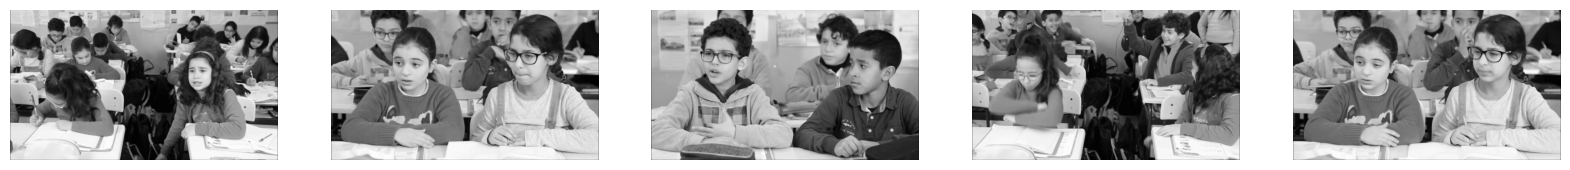

In [53]:
if __name__ == "__main__":
    folder_path = "denoised_images"
    num_images_to_show = 5
    show_random_images_grayScale(folder_path, num_images_to_show)

##  ***4. Amélioration de la qualité des images (contraste, luminosité).***

#### *Cette fonction **enhance_images** améliore la qualité des images situées dans un dossier d'entrée en ajustant le contraste et la luminosité.* 

#### ***alpha:** C'est le facteur de multiplication qui ajuste le contraste de l'image. Une valeur d'alpha supérieure à 1 augmentera le contraste, tandis qu'une valeur inférieure à 1 le diminuera. Un alpha égal à 1 signifie qu'aucun changement de contraste n'est appliqué.*

#### ***beta:** C'est le facteur d'ajustement d'addition qui ajuste la luminosité de l'image. Une valeur d'beta positive augmentera la luminosité, tandis qu'une valeur négative la diminuera. Un beta égal à 0 signifie qu'aucun changement de luminosité n'est appliqué.*

#### *La fonction effectue les calculs suivants pour chaque pixel de l'image source (**src**) afin de produire l'image de sortie (**enhanced_image**):*
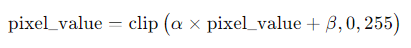

In [55]:
def enhance_images(input_folder, output_folder, alpha=1.2, beta=6):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Liste des fichiers dans le dossier d'entrée
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # Chemin complet de l'image d'entrée
        input_path = os.path.join(input_folder, image_file)

        # Lire l'image en niveaux de gris
        gray_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Ajuster le contraste et la luminosité
        enhanced_image = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)

        # Chemin complet de l'image de sortie
        output_path = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}.jpg")

        # Enregistrer l'image traitée
        cv2.imwrite(output_path, enhanced_image)
        
    print(f"Les Images sont bien enregistrées après l'amélioration de la qualité dans ce dossier : {output_folder}")

In [56]:
if __name__ == "__main__":
    input_folder = "denoised_images"
    output_folder = "enhaced_images"
    alpha = 1.2  
    beta = 6   

    enhance_images(input_folder, output_folder, alpha, beta)

Les Images sont bien enregistrées après l'amélioration de la qualité dans ce dossier : enhaced_images


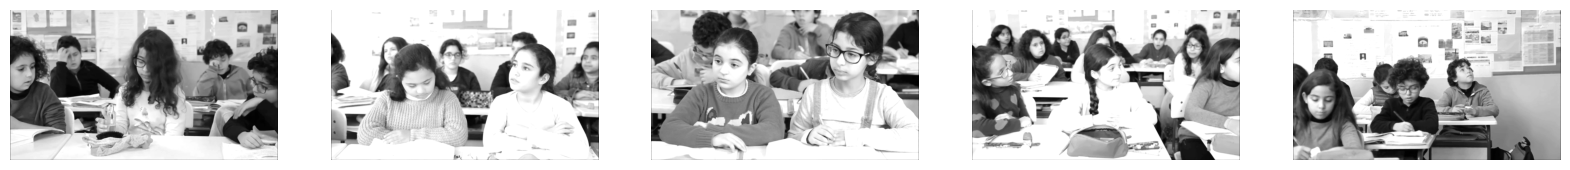

In [57]:
if __name__ == "__main__":
    folder_path = "enhaced_images"
    num_images_to_show = 5
    show_random_images_grayScale(folder_path, num_images_to_show)

##  ***5. Détection des contours en utilisant Canny.***

#### *La fonction **detect_edges** prend un dossier d'images en entrée, applique la détection de contours Canny sur chaque image en niveaux de gris, et enregistre les images résultantes avec les contours détectés dans un dossier de sortie.*

In [60]:
def detect_edges(input_folder, output_folder, low_threshold=50, high_threshold=150):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Liste des fichiers dans le dossier d'entrée
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # Chemin complet de l'image d'entrée
        input_path = os.path.join(input_folder, image_file)

        # Lire l'image en niveaux de gris
        gray_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Appliquer la détection de contours Canny
        edges = cv2.Canny(gray_image, low_threshold, high_threshold)

        # Convertir l'image résultante en format BGR (pour pouvoir l'enregistrer avec cv2.imwrite)
        edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

        # Chemin complet de l'image de sortie
        output_path = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}.jpg")

        # Enregistrer l'image avec contours détectés
        cv2.imwrite(output_path, edges_bgr)
    
    print(f"Les Contours détectés sont bien enregistrés : {output_folder}")

In [61]:
if __name__ == "__main__":
    input_folder = "enhaced_images"
    output_folder = "detected_contours"
    low_threshold = 50   # Seuil bas pour Canny
    high_threshold = 150  # Seuil haut pour Canny

    detect_edges(input_folder, output_folder, low_threshold, high_threshold)

Les Contours détectés sont bien enregistrés : detected_contours


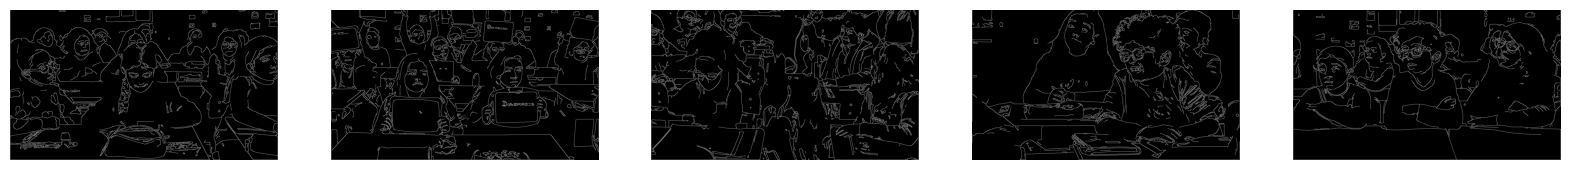

In [62]:
if __name__ == "__main__":
    folder_path = "detected_contours"
    num_images_to_show = 5
    show_random_images_grayScale(folder_path, num_images_to_show)

##  ***6. Détection des visages.***

#### *La fonction **detect_faces** prend en entrée un dossier contenant des images et crée une sortie avec des rectangles dessinés autour des visages détectés dans chaque image.*

In [73]:
def detect_faces(input_folder, output_folder):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialiser le détecteur de visages de dlib
    # Ce détecteur utilise un modèle de machine learning pour identifier 
    # les caractéristiques typiques d'un visage humain et localiser ces visages dans une image.
    face_detector = dlib.get_frontal_face_detector()

    # Liste des fichiers dans le dossier d'entrée
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # Chemin complet de l'image d'entrée
        input_path = os.path.join(input_folder, image_file)

        # Lire l'image
        image = cv2.imread(input_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Détecter les visages dans l'image
        faces = face_detector(gray_image)

        # Vérifier si des visages ont été détectés
        if faces:
            # Dessiner des rectangles autour des visages sur l'image
            image_with_faces = image.copy()
            for face in faces:
                cv2.rectangle(image_with_faces, (face.left(), face.top()), (face.right(), face.bottom()), (0, 255, 0), 2)

            # Chemin complet de l'image de sortie avec les visages détectés
            output_path_with_faces = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}.jpg")
            cv2.imwrite(output_path_with_faces, image_with_faces)
    print(f"les Visages détectés sur les images sont bien enregistrée dans ce dossier : {output_folder}")

In [74]:
if __name__ == "__main__":
    input_folder = "enhaced_images"
    output_folder = "faces_detected"

    detect_faces(input_folder, output_folder)

les Visages détectés sur les images sont bien enregistrée dans ce dossier : faces_detected


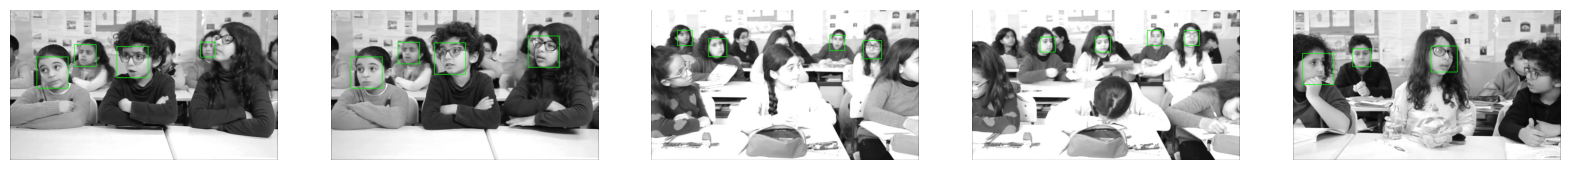

In [75]:
if __name__ == "__main__":
    folder_path = "faces_detected"
    num_images_to_show = 5
    show_random_images_grayScale(folder_path, num_images_to_show)

##  ***7. Détection des yeux.***

#### *Cette fonction utilise la bibliothèque dlib pour détecter les visages dans des images, puis utilise un prédicteur de points de visage pour identifier et marquer les positions des yeux dans chaque visage détecté.*

In [76]:
def detect_eyes(input_folder, output_folder):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialiser le détecteur de visages de dlib
    face_detector = dlib.get_frontal_face_detector()
    
    # Initialiser le prédicteur de points de visage pour détecter les yeux
    # Ce prédicteur utilise un modèle pré-entraîné pour prédire les positions des points caractéristiques du visage, y compris les yeux.
    eye_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    # Liste des fichiers dans le dossier d'entrée
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # Chemin complet de l'image d'entrée
        input_path = os.path.join(input_folder, image_file)

        # Lire l'image
        image = cv2.imread(input_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Détecter les visages dans l'image
        faces = face_detector(gray_image)

        # Pour chaque visage détecté, elle utilise le prédicteur de points de visage pour
        # Détecter les points d'intérêts des yeux 
        image_with_eyes = image.copy()
        # La boucle for n in range(36, 48): parcourt les indices des points caractéristiques correspondant aux yeux dans 
        # la liste des landmarks retournée par le prédicteur.
        for face in faces:
            landmarks = eye_predictor(gray_image, face)
            for n in range(36, 48):  # Les indices 36 à 47 représentent les yeux dans les landmarks
                # Pour chaque indice n, les coordonnées (x, y) du point caractéristique correspondant
                x, y = landmarks.part(n).x, landmarks.part(n).y
                # Les cercles ont un rayon de 2 pixels, une couleur verte (0, 255, 0 dans le format BGR),
                # et la valeur -1 indique de remplir le cercle.
                cv2.circle(image_with_eyes, (x, y), 2, (0, 255, 0), -1)

        # Chemin complet de l'image de sortie
        output_path = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}.jpg")

        # Enregistrer l'image avec les yeux détectés
        cv2.imwrite(output_path, image_with_eyes)
        
    print(f"Les Yeux détectés avec le modèle ML sont bien enregistrés dans : {output_folder}")

#### *Sur cette image, on peut voir un ensemble de 68 points faciaux étiquetés avec des coordonnées spécifiques entourant certaines parties du visage, pour :*

#### ***POINTS DE L'ŒIL DROITE :** 43 à 48*
#### ***POINTS DE L'ŒIL GAUCHE :** 37 à 42*

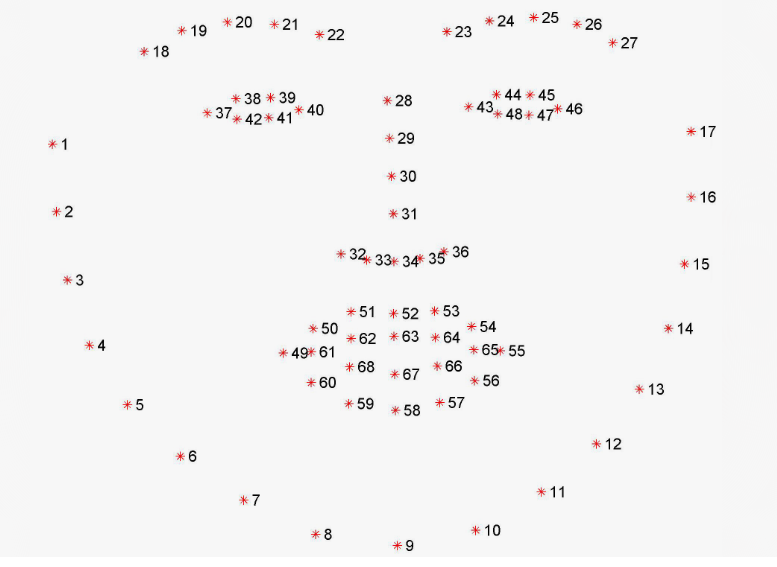

In [77]:
if __name__ == "__main__":
    input_folder = "enhaced_images"
    output_folder = "eyes_deteced"

    detect_eyes(input_folder, output_folder)

Les Yeux détectés avec le modèle ML sont bien enregistrés dans : eyes_deteced


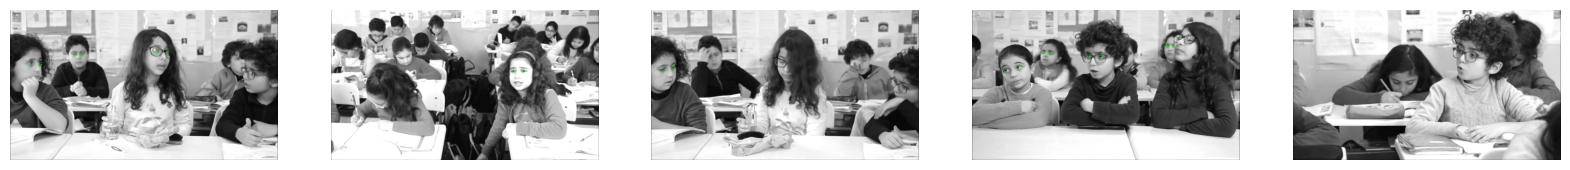

In [78]:
if __name__ == "__main__":
    folder_path = "eyes_deteced"
    num_images_to_show = 5
    show_random_images_grayScale(folder_path, num_images_to_show)

##  ***8. Application de techniques de morphologie (érosion).***

#### *La fonction **apply_erosion** prend en entrée un dossier contenant des images, applique une opération d'érosion à chaque image en niveaux de gris, et enregistre les images résultantes dans un dossier de sortie.*

#### *Dans le contexte de la détection des yeux, l'érosion peut être utilisée pour réduire les zones de pixels autour des yeux, rendant ainsi les yeux plus distincts et facilitant potentiellement leur détection.*

In [79]:
def apply_erosion(input_folder, output_folder):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Liste des fichiers dans le dossier d'entrée
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # Chemin complet de l'image d'entrée
        input_path = os.path.join(input_folder, image_file)

        # Lire l'image en niveaux de gris
        gray_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Appliquer une opération d'érosion
        kernel = np.ones((5,5), np.uint8)
        eroded_image = cv2.erode(gray_image, kernel, iterations=1)

        # Chemin complet de l'image de sortie après érosion
        output_path_eroded = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}.jpg")

        # Enregistrer l'image après érosion
        cv2.imwrite(output_path_eroded, eroded_image)

    print(f"Les Images après l'érosion sont bien enregistrées dans : {output_folder}")

In [80]:
if __name__ == "__main__":
    input_folder = "enhaced_images"
    output_folder = "morphologies_images"

    apply_erosion(input_folder, output_folder)

Les Images après l'érosion sont bien enregistrées dans : morphologies_images


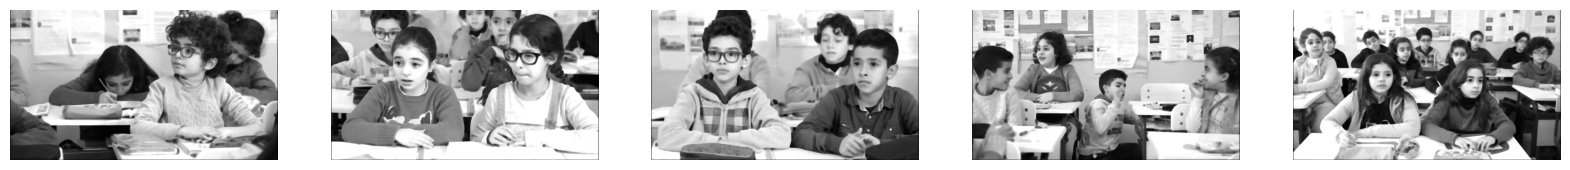

In [81]:
if __name__ == "__main__":
    folder_path = "morphologies_images"
    num_images_to_show = 5
    show_random_images_grayScale(folder_path, num_images_to_show)

In [82]:
if __name__ == "__main__":
    input_folder = "morphologies_images"
    output_folder = "eyes_detected_eroded"

    detect_eyes(input_folder, output_folder)

Les Yeux détectés avec le modèle ML sont bien enregistrés dans : eyes_detected_eroded


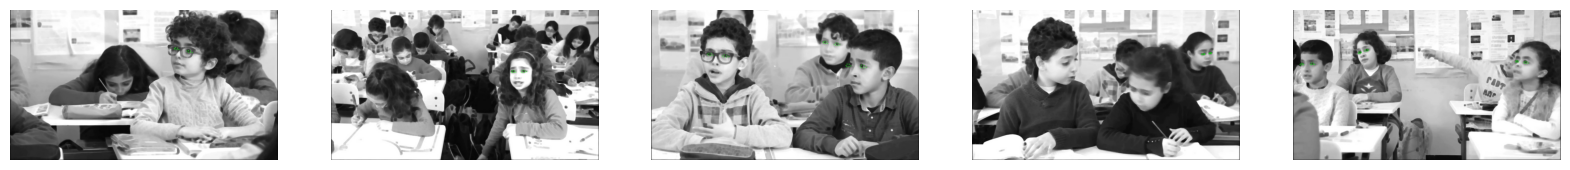

In [83]:
if __name__ == "__main__":
    folder_path = "eyes_detected_eroded"
    num_images_to_show = 5
    show_random_images_grayScale(folder_path, num_images_to_show)

##  ***9. Récupération des points d'intérêts (p1,...p6).***

#### *La fonction **detect_eyes_ear** utilise le détecteur de visages de dlib pour localiser les visages dans chaque image d'un dossier d'entrée.*


#### *Pour chaque visage détecté, elle utilise un prédicteur de points de visage pour identifier les coordonnées des yeux.*


#### *Ensuite, la fonction dessine des cercles autour des yeux sur une copie de l'image originale, enregistre cette image modifiée dans un dossier de sortie, et calcule l'Eye Aspect Ratio (EAR) pour chaque œil.*


#### *L'EAR est une mesure de la fermeture des yeux, calculée en évaluant les rapports de distances entre des points spécifiques autour des yeux.*
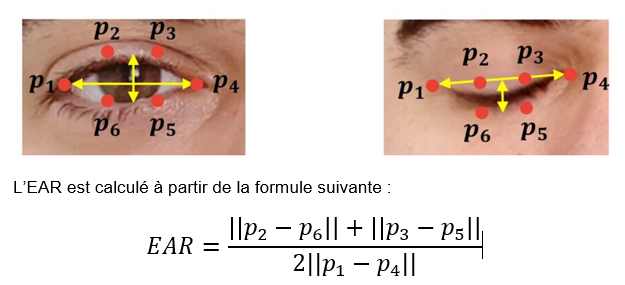

#### *Ces valeurs d'EAR sont ensuite enregistrées dans un fichier CSV associé à chaque image.*

In [4]:
def eye_aspect_ratio(eye):
    # Convertir la liste des tuples en tableau NumPy
    eye = np.array(eye)
    
    # Distances verticales entre les landmarks des yeux
    v1 = np.linalg.norm(eye[1] - eye[5])
    v2 = np.linalg.norm(eye[2] - eye[4])
    
    # Distance horizontale entre les coins des yeux
    h = np.linalg.norm(eye[0] - eye[3])
    
    # Eye aspect ratio
    ear = (v1 + v2) / (2 * h)
    return ear

def detect_eyes_ear(input_folder, output_folder, output_images):
    # Vérifier si le dossier de sortie existe, le créer si ce n'est pas le cas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    if not os.path.exists(output_images):
        os.makedirs(output_images)

    # Initialiser le detecteur de visage
    face_detector = dlib.get_frontal_face_detector()

    #  Initialiser le prédicteur pour la détection des yeux
    eye_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    # Créer le fichier CSV pour sauvegarder les valeurs de l'EAR 
    csv_file_path = os.path.join(output_folder, "ear_values.csv")
    with open(csv_file_path, mode='w', newline='') as csvfile:
        fieldnames = ['Image', 'EAR']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Liste des fichiers dans le dossier d'entrée
        image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for image_file in image_files:
            # Chemin complet de l'image d'entrée
            input_path = os.path.join(input_folder, image_file)

            # Lire l'image
            image = cv2.imread(input_path)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Détecter les visages dans l'image
            faces = face_detector(gray_image)

            # Vérifier si des visages sont détectés
            if faces:
                # Créer une copie de l'image pour dessiner les cercles sans affecter l'originale
                image_with_eyes = image.copy()

                # Dessiner des cercles autour des yeux sur la copie de l'image
                for face in faces:
                    landmarks = eye_predictor(gray_image, face)
                    for n in range(36, 48):  # Les indices 36 à 47 représentent les yeux dans les landmarks
                        x, y = landmarks.part(n).x, landmarks.part(n).y
                        cv2.circle(image_with_eyes, (x, y), 2, (0, 255, 0), -1)

                # Chemin complet de l'image de sortie avec les yeux détectés
                output_path_with_eyes = os.path.join(output_images, f"{os.path.splitext(image_file)[0]}.jpg")
                cv2.imwrite(output_path_with_eyes, image_with_eyes)

                # Calculer et enregistrer l'EAR pour chaque œil dans l'image
                for face in faces:
                    landmarks = eye_predictor(gray_image, face)
                    left_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
                    right_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
                    
                    # Calculer l'EAR pour les yeux gauche et droit
                    ear_left = eye_aspect_ratio(left_eye)
                    ear_right = eye_aspect_ratio(right_eye)
                    
                    # EAR moyen des deux yeux
                    ear_avg = (ear_left + ear_right) / 2

                    # Enregistrer la valeur de l'EAR dans le fichier CSV
                    writer.writerow({'Image': image_file, 'EAR': ear_avg})

        print(f"EAR calculé")
        print(f"Les Images avec yeux détectés sont bien enregistrées dans : {output_images}")

In [107]:
if __name__ == "__main__":
    input_folder = "morphologies_images"
    output_csv = "ear_results"
    output_images = os.path.join(output_csv, "images")

    detect_eyes_ear(input_folder, output_csv, output_images)

EAR calculé
Les Images avec yeux détectés sont bien enregistrées dans : ear_results\images


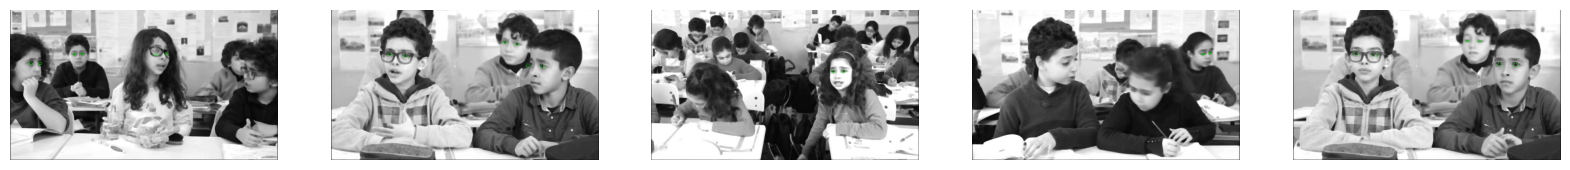

In [108]:
if __name__ == "__main__":
    folder_path = "ear_results/images"
    num_images_to_show = 5
    show_random_images_grayScale(folder_path, num_images_to_show)

#### *Voilà Un extrait des valeurs de Ears de ficier CSV les ligne de meme couleurs représentent les personnes dans une meme image*
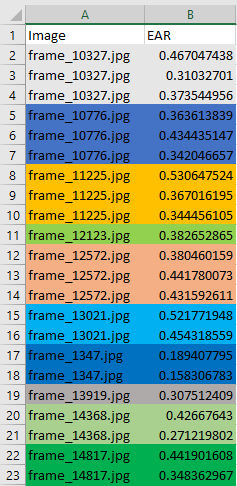
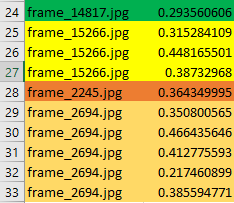
### *Les 5 dernières lignes représentes les valeurs de EARS de l'image suivante*
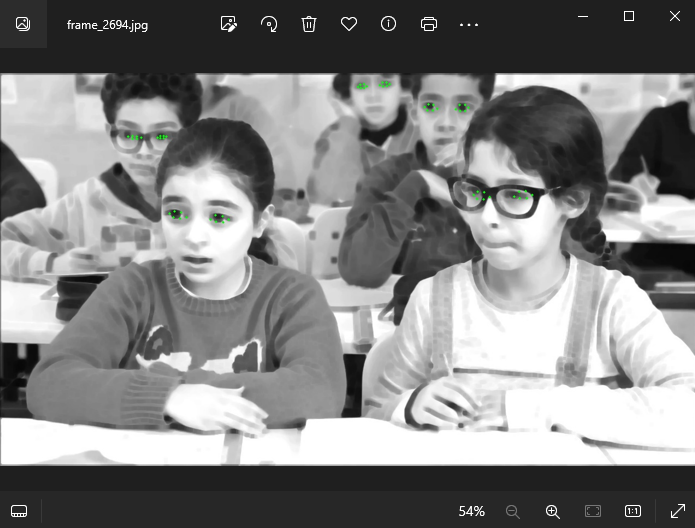

##  ***10. Détection de la Fatigue à partir de la vidéo avec une alerte sonore.***

#### *La fonction **detect_eyes_and_alert** utilise des techniques de vision par ordinateur pour analyser un flux vidéo, détecter les visages et les yeux dans chaque image. Elle surveille le Rapport d'Aspect des Yeux (EAR) comme indicateur de l'ouverture des yeux et déclenche une alerte en cas de détection de fatigue.*

In [5]:
# Initialiser le mixeur pygame pour les alertes sonores
pygame.mixer.init()

def play_alert_sound():
    # le fichier de son
    pygame.mixer.music.load("beep-warning-6387.mp3")  
    pygame.mixer.music.play()
    pygame.mixer.music.set_volume(1.0)     

# ear_threshold : Le seuil EAR en dessous duquel la fatigue est détectée.
# consecutive_frames_threshold : Le nombre d'images consécutives où l'EAR doit être inférieur au seuil pour déclencher une alerte.
# skip_frames : Le nombre d'images à sauter entre les analyses pour des raisons d'efficacité.
def detect_eyes_and_alert(video_path, ear_threshold=0.35, consecutive_frames_threshold=5, skip_frames=2):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    cap = cv2.VideoCapture(video_path)

    consecutive_frames = 0
    frame_count = 0
    alert_start_time = {i: 0 for i in range(100)}

    def alarm():
        print("Fatigue detected!")
        play_alert_sound()

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        if frame_count % skip_frames != 0:
            frame_count += 1
            continue

        frame = imutils.resize(frame, width=800)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        alert_triggered = False

        for face_id, face in enumerate(faces):
            landmarks = predictor(gray, face)
            left_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
            right_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

            left_ear = eye_aspect_ratio(left_eye)
            right_ear = eye_aspect_ratio(right_eye)

            avg_ear = (left_ear + right_ear) / 2

            if avg_ear < ear_threshold:
                consecutive_frames += 1
                if consecutive_frames == 1:
                    alert_start_time[face_id] = time.time()

                if consecutive_frames >= consecutive_frames_threshold and time.time() - alert_start_time[face_id] >= consecutive_frames_threshold * skip_frames:
                    print(f"Alert triggered for person {face_id + 1}. EAR: {avg_ear}")
                    t = Thread(target=alarm)
                    t.deamon = True
                    t.start()
                    alert_triggered = True

            else:
                consecutive_frames = 0

            color = (0, 255, 0) if not alert_triggered else (0, 0, 255)  # Green if no alert, red if alert triggered
            cv2.rectangle(frame, (face.left(), face.top()), (face.right(), face.bottom()), color, 2)
            for eye in left_eye + right_eye:
                x, y = eye
                cv2.circle(frame, (x, y), 2, color, -1)

            # Display EAR value for each student
            cv2.putText(frame, f"EAR: {avg_ear:.2f}", (face.left(), face.top() - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        cv2.imshow('Frame', frame)
        key = cv2.waitKey(1) & 0xFF

        if key == ord("q"):
            break

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()

In [8]:
if __name__ == "__main__":
    video_path = "Scènes_Classe.mp4"  
    detect_eyes_and_alert(video_path)

Alert triggered for person 2. EAR: 0.12433288089711644
Fatigue detected!
Alert triggered for person 2. EAR: 0.12110030810665087
Fatigue detected!
Alert triggered for person 2. EAR: 0.11708257267220815
Fatigue detected!
Alert triggered for person 2. EAR: 0.12456821978060995
Fatigue detected!
Alert triggered for person 2. EAR: 0.12478410989030497
Fatigue detected!
Alert triggered for person 2. EAR: 0.15930678773503
Fatigue detected!
Alert triggered for person 2. EAR: 0.15930678773503
Fatigue detected!
Alert triggered for person 2. EAR: 0.12855966511831968
Fatigue detected!
Alert triggered for person 2. EAR: 0.14469510009324896
Fatigue detected!
Alert triggered for person 2. EAR: 0.10357151093368146
Fatigue detected!
Alert triggered for person 2. EAR: 0.10380684981717496
Fatigue detected!
Alert triggered for person 2. EAR: 0.08304547985373997
Fatigue detected!
Alert triggered for person 2. EAR: 0.10024476187834032
Fatigue detected!
Alert triggered for person 2. EAR: 0.10885187117436462
Fa